# Part 2


In [1]:
import numpy as np
import random
import math
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
N_WORLD_FEATURES = 5  #the temporal context model assumes that the past becomes increasingly
N_ITEMS = 10          #dissimilar to the future, so that memories become harder to retrieve the
ENCODING_TIME = 500   #farther away in the past they are
TEST_TIME = 20

In [3]:
schedule =np.column_stack((np.sort(np.round(np.random.random(N_ITEMS)*500)),np.arange(N_ITEMS)))
schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
schedule_load

17.857142857142858

In [4]:
def generatemixgaussian():
#     numpy.random.seed(0x5eed)
    mean=[0,1]
    var=0.2
    y=list()
    for i in range(10000):
        sample=np.random.choice(2,1,p=[0.5,0.5])
        y.append(stats.norm.rvs(mean[sample[0]],var))
    y=np.array(y)
    x_eval = np.linspace(y.min(), y.max(), 400)
    bimodal_pdf = stats.norm.pdf(x_eval, loc=mean[0], scale=var)*0.5 + stats.norm.pdf(x_eval, loc=mean[1], scale=var) *0.5
    plt.plot(x_eval, bimodal_pdf, 'r--', label="Actual PDF")
    plt.hist(y, density=True, bins=20)
    plt.title("small mean: 0;large mean 1;var in both=0.2")
    plt.savefig('mixgaussian.png',bbox='tight')
    plt.show()
    return np.array(y)

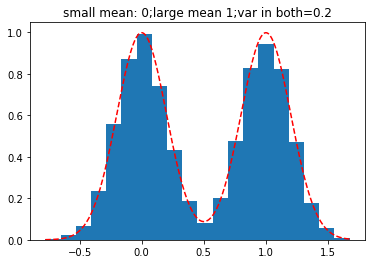

In [5]:
mixmodel=generatemixgaussian()

In [6]:
world_m = np.array([1 ,2 ,1, 2, 3])          
world_var = 1
delta = np.random.choice(mixmodel)                
beta_param = 0.001      #context drift parameter, ct=beta*ct + c_t-1      
m = 0

In [7]:
def drawFromADist(p):
    if(np.sum(p)==0):
        p = 0.05*np.ones(len(p))
    p=p/np.sum(p)
    c=np.cumsum(p)
    idx=np.where((np.random.random(1)-np.cumsum(p))<0)
    sample=np.min(idx)
    out = np.zeros(len(p))
    out[sample] = 1
#     out[out==0] = 0.1
    return out

#### Simulation encoding

In [8]:
for time in range(1,ENCODING_TIME):
    world_m = world_m + delta
    #world_m = beta_param*world_m + delta
    world = np.random.normal(world_m, world_var)
    delta=np.random.choice(mixmodel)
    if(m<N_ITEMS):
        if(time==schedule[m,0]):
            encoding[m,0:5] =  world
            encoding[m,5]=m     #encoding world context and item
            m =  m + 1

#### Simulating retrieval using SAM, but with a bijective image-item mapping

In [9]:
out=np.zeros(TEST_TIME)
while(time<ENCODING_TIME+TEST_TIME):
    delta=np.random.choice(mixmodel)
    world_m = world_m + delta
    #world_m = beta_param*world_m + delta
    world = np.random.normal(world_m, world_var)
    soa=np.zeros(N_ITEMS)
    temp=np.zeros(N_WORLD_FEATURES+1)
    for m in range(N_ITEMS):
        temp[0:5] =  world
        temp[5]=m
        soa[m]=np.dot(encoding[m,0:-1],temp[0:-1].T)     
    soa=soa/np.linalg.norm(soa)
    out[time-ENCODING_TIME] = np.where(drawFromADist(soa)>0)[0]
    time = time + 1

In [10]:
success=len(np.unique(out))
print("Success is {} with scheduling load {}".format(success,schedule_load))

Success is 8 with scheduling load 17.857142857142858


### Over multiple trial with different scheduling policy

In [11]:
def model(schedule):
    N_WORLD_FEATURES = 5
    N_ITEMS = 10
    ENCODING_TIME = 500
    TEST_TIME = 20
    schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
    encoding = np.zeros((N_ITEMS,N_WORLD_FEATURES+1))
    
    
    world_m = np.array([1 ,2 ,1, 2, 3])          
    world_var = 1
    delta = np.random.choice(mixmodel)                  
    beta_param = 0.001      #context drift parameter, ct=beta*ct + c_t-1      
    m = 0
    
    #########encoding########################################
    for time in range(1,ENCODING_TIME):
        world_m = world_m + delta
        #world_m = beta_param*world_m + delta
        world = np.random.normal(world_m, world_var)
        delta=np.random.choice(mixmodel)
        sample=random.randint(0,1)
        delta=np.random.normal(world_m[sample], world_var)
        if(m<N_ITEMS):
            if(time==schedule[m,0]):
                encoding[m,0:5] =  world
                encoding[m,5]=m     #encoding world_context and item
                m =  m + 1
     
    ########################################retrieval##########################
    out=np.zeros(TEST_TIME)
    while(time<ENCODING_TIME+TEST_TIME):
        delta=np.random.choice(mixmodel)
        world_m = world_m + delta
        #world_m = beta_param*world_m + delta
        world = np.random.normal(world_m, world_var)
        soa=np.zeros(N_ITEMS)
        temp=np.zeros(N_WORLD_FEATURES+1)
        for m in range(N_ITEMS):
            temp[0:5] =  world
            temp[5]=m
            soa[m]=np.dot(encoding[m,0:-1],temp[0:-1].T)     
        soa=soa/np.linalg.norm(soa)
        out[time-ENCODING_TIME] = np.where(drawFromADist(soa)>0)[0]
        time = time + 1
    return len(np.unique(out)),schedule_load

In [12]:
def check_plot(schedule,name='fig'):
    schedule_load = ENCODING_TIME/np.median(np.diff(schedule[:,0]))
    x=[model(schedule) for i in range(100)]
    x=np.array(x)
    plt.plot(np.arange(100),x[:,0],c='orange')
    plt.ylabel('Success')
    plt.xlabel('No of iteration')
    plt.title('Mean Success is '+str(np.mean(x[:,0]))+" with scheduling load "+str(schedule_load))
    plt.savefig(name,bbox='tight')
    plt.show()
    print(schedule)

#### Inoder to minimize scheduling load ;median of difference should be maximum(and also we have to make sure success >7), we have tried:

### 1)  Shoving at end of encoding period 


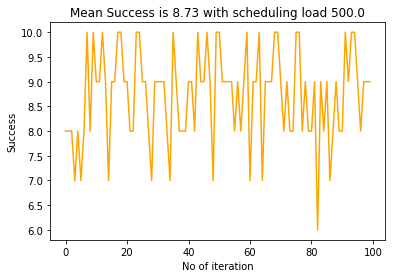

[[490   0]
 [491   1]
 [492   2]
 [493   3]
 [494   4]
 [495   5]
 [496   6]
 [497   7]
 [498   8]
 [499   9]]


In [13]:
schedule=np.column_stack((np.sort(np.arange(490,500)),np.arange(N_ITEMS)))
check_plot(schedule,name="Shoving_at_end")

### 2) Truncated Gaussian

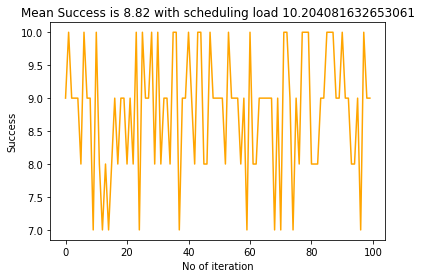

[[ 29.   0.]
 [ 78.   1.]
 [ 78.   2.]
 [187.   3.]
 [300.   4.]
 [301.   5.]
 [354.   6.]
 [366.   7.]
 [433.   8.]
 [475.   9.]]


In [14]:
lower, upper = 0, 1
np.random.seed(42)
mu, sigma = 1,12
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
N = stats.norm(loc=mu, scale=sigma)
X=X.rvs(10)
schedule =np.column_stack((np.sort(np.round(X*500)),np.arange(N_ITEMS)))
check_plot(schedule,name="truncated_gaussian")

### 3) Regular sized Interval

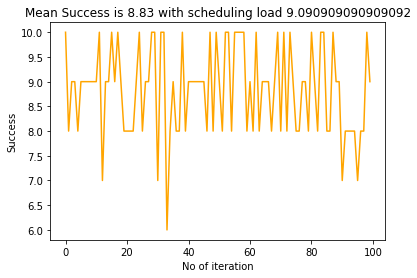

[[  3   0]
 [ 58   1]
 [113   2]
 [168   3]
 [223   4]
 [278   5]
 [333   6]
 [388   7]
 [443   8]
 [498   9]]


In [15]:
start=3
end=500
step=(end-start)//9
x=np.arange(start,end,step)
schedule =np.column_stack((np.sort(np.arange(start,end,step)[0:10]),np.arange(N_ITEMS)))
check_plot(schedule,name='Regular_size_interval')

### 4) Logarithmic interval

#### This is the best we get algorithmically

In [16]:
#     1          2        3      4     5    6    7   8  9 10
#     +----------+--------+------+-----+----+----+---+--+-+

In [17]:
start = 0.0
end = 1.0;
total= 10
scale = (end - start) / math.log(total);
lower_bound = 0;
x=list()
for i in range(total):
    upper_bound = start + 0.25*(i+1)* scale
    x.append(lower_bound*500)
    lower_bound = upper_bound
x[-1]=499
x[0]=1

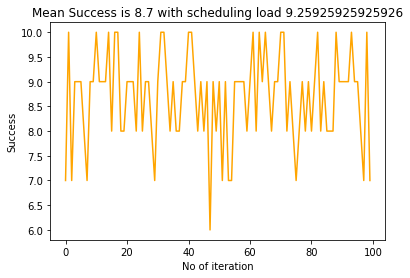

[[  1.   0.]
 [ 54.   1.]
 [109.   2.]
 [163.   3.]
 [217.   4.]
 [271.   5.]
 [326.   6.]
 [380.   7.]
 [434.   8.]
 [499.   9.]]


In [18]:
schedule =np.column_stack((np.sort(np.round(x)),np.arange(N_ITEMS)))
check_plot(schedule,name='logarthmic_interval')

# Best Optimal by maximizing median

## we shove first five at regular interval of 100 starting from 0 and last 5 at the end(496 to 500)

#### This will make median around 100, giving scheduling load around 5

In [19]:
g=[1, 100, 200, 300, 400, 495, 496, 497, 498,499]  

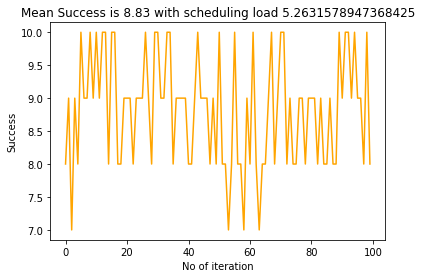

[[  1   0]
 [100   1]
 [200   2]
 [300   3]
 [400   4]
 [495   5]
 [496   6]
 [497   7]
 [498   8]
 [499   9]]


In [20]:
schedule =np.column_stack((np.sort(g),np.arange(N_ITEMS)))
check_plot(schedule,name='Optimal_policy')

In [21]:
########################END##########################################################################